In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import hodel.dismech as dismech
from typing import Any

jax.config.update("jax_enable_x64", True)

In [3]:
# Single triplet connectivity
conn = dismech.Connectivity(
    dismech.map_node_to_dof(jnp.empty((0,2), dtype=jnp.int32)),
    jnp.empty((0), dtype=jnp.int32),
    jnp.empty((0, 2), dtype=jnp.int32),
    jnp.empty((0, 2), dtype=jnp.int32),
    jnp.empty((0, 2), dtype=jnp.int32),
    dismech.map_node_to_dof(jnp.array([0, 1, 2, 3])),
)


def get_state(seed: int = 42) -> dismech.StaticState:
    x0 = jax.random.uniform(jax.random.key(seed), [12])
    return dismech.StaticState.init(x0, conn)


def update_and_get_energy(triplet):
    def func(x, Theta, state0):
        state = state0.update(x, conn)
        return triplet.get_energy(state, Theta)

    return func


def get_random_des_hinge(
    state: dismech.StaticState, seed: int = 42
) -> dismech.DESHinge:
    key = jax.random.key(seed)
    ks = jax.random.uniform(key, [1])
    kb = jax.random.uniform(key, [1])
    l_0 = jnp.linalg.norm(state.q[0:3] - state.q[3:6])
    l_1 = jnp.linalg.norm(state.q[0:3] - state.q[6:9])
    l_2 = jnp.linalg.norm(state.q[0:3] - state.q[9:12])
    l_3 = jnp.linalg.norm(state.q[3:6] - state.q[6:9])
    l_4 = jnp.linalg.norm(state.q[3:6] - state.q[9:12])
    return dismech.DESHinge.init(
        dismech.map_node_to_dof(jnp.array([0, 1, 2, 3])),
        jnp.array([l_0, l_1, l_2, l_3, l_4]),
        ks,
        kb,
        state,
    )


def test_energy_stretch_linear_elastic(
    stencil,
    state: dismech.StaticState,
    seed: int = 10,
    Theta: Any = None,
    change: float = 1e-3,
):
    get_energy = update_and_get_energy(stencil)

    # Deformed state
    x = jax.random.uniform(jax.random.key(seed), [state.q.shape[0]])
    hess = jax.hessian(get_energy, 0)(x, Theta, state)
    energy_ground, grad = jax.value_and_grad(get_energy, 0)(x, Theta, state)

    # FDM
    grad_fdm = jnp.zeros_like(x)
    hess_fdm = jnp.zeros((x.shape[0], x.shape[0]))

    for c in range(x.shape[0]):
        x_plus = x.at[c].add(change)

        energy_plus = get_energy(x_plus, Theta, state)
        grad_fdm = grad_fdm.at[c].set((energy_plus - energy_ground) / change)

        grad_change = jax.grad(get_energy, 0)(x_plus, Theta, state)
        hess_fdm = hess_fdm.at[:, c].set((grad_change - grad) / change)

    # Plot gradients
    plt.figure(1)
    plt.plot(grad, "ro", label="Analytical")
    plt.plot(grad_fdm, "b^", label="Finite Difference")
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Gradient")
    plt.title("Forces (Gradients) Comparison")
    plt.show()

    # Plot Hessians
    plt.figure(2)
    plt.plot(hess.flatten(), "ro", label="Analytical")
    plt.plot(hess_fdm.flatten(), "b^", label="Finite Difference")
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Hessian")
    plt.title("Hessian Comparison")
    plt.show()


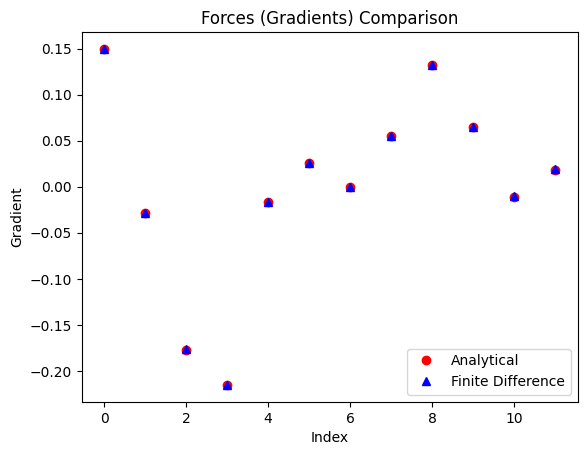

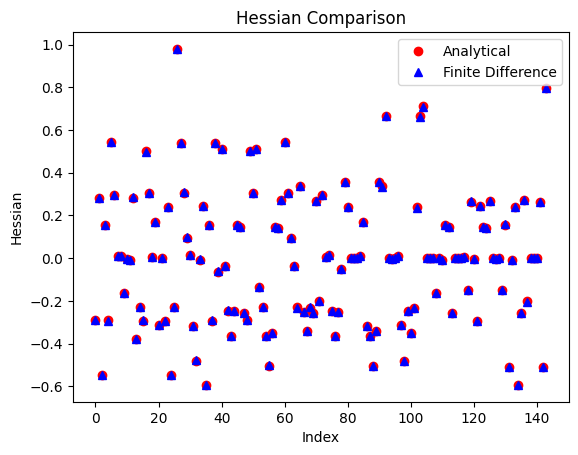

In [4]:
state = get_state()
test_energy_stretch_linear_elastic(get_random_des_hinge(state), state)

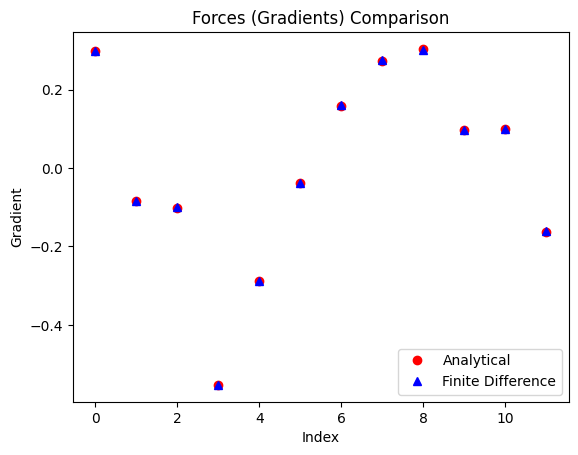

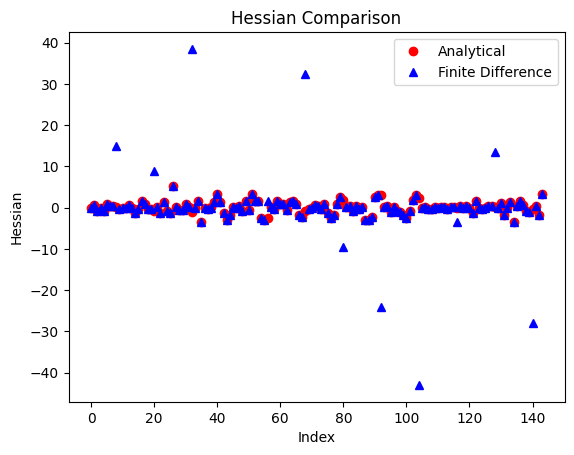

In [9]:
from dataclasses import dataclass
from jax.tree_util import register_dataclass
import flax.linen as nn
from typing import cast


def get_nn_hinge_cls():
    def vector_to_psd_matrix(values: jax.Array, n: int = 5) -> jax.Array:
        """Convert vector to PSD matrix via Cholesky."""
        L = jnp.zeros((n, n))
        tril_indices = jnp.tril_indices(n)
        L = L.at[tril_indices].set(values)

        # Ensure positive diagonal
        diag_indices = jnp.diag_indices(n)
        L = L.at[diag_indices].set(jax.nn.softplus(L[diag_indices]) + 1e-6)

        return L @ L.T

    class Model(nn.Module):
        dmid: int

        @nn.compact
        def __call__(self, x):
            x = nn.Dense(self.dmid)(x)
            x = nn.relu(x)
            x = nn.Dense(self.dmid)(x)
            x = nn.relu(x)
            # Output 15 values for 5x5 Cholesky factor
            values = nn.Dense(21)(x)
            # Convert to PSD matrix
            return vector_to_psd_matrix(values, n=6)

    model = Model(dmid=64)

    @register_dataclass
    @dataclass(frozen=True)
    class NNHinge(dismech.Hinge):
        def get_K(self, del_strain: jax.Array, Theta: dict) -> jax.Array:
            return cast(jax.Array, model.apply(Theta, del_strain))

    params = model.init(jax.random.PRNGKey(4), jnp.zeros(6))
    return NNHinge, params


MyHinge, params = get_nn_hinge_cls()


def get_random_my_hinge(state: dismech.StaticState):
    l_0 = jnp.linalg.norm(state.q[0:3] - state.q[3:6])
    l_1 = jnp.linalg.norm(state.q[0:3] - state.q[6:9])
    l_2 = jnp.linalg.norm(state.q[0:3] - state.q[9:12])
    l_3 = jnp.linalg.norm(state.q[3:6] - state.q[6:9])
    l_4 = jnp.linalg.norm(state.q[3:6] - state.q[9:12])
    return MyHinge.init(
        dismech.map_node_to_dof(jnp.array([0, 1, 2, 3])),
        jnp.array([l_0, l_1, l_2, l_3, l_4]),
        state,
    )


test_energy_stretch_linear_elastic(get_random_my_hinge(state), state, Theta=params)